In [232]:
# start with importing the libraries we need
%matplotlib inline
import numpy as np
import brian2 as b2
import matplotlib.pyplot as plt

In [233]:
# Define all the parameters
tau_m=10*b2.ms
v0=-50*b2.mV
eta=0*b2.mV
v_rest=15*b2.mV
R=50*b2.ohm
beta=10e5*b2.Hz

1. Consider N = 100 non-interacting neurons, with initial voltages $v_i(t = 0)$ uniformly distributed at random between $v_0$ and $η$ (i.e. $v_i(0) ∼ U([v_0,η])$), and submitted to an oscillating external input $I_{ext}(t) = I_0(1 + sin(ωt))$, with $I_0 = 0.5 mA$, $ω = 10^2 s^{−1}(= 0.1 ms^{−1})$. <br>
• Compute the membrane potentials $v_i(t)$ and firing times of the neurons, for $t ≤ T_f = 100 ms$. <br>
• Plot the voltage $v_i(t)$ of the first neuron, along with the external input $RI_{ext}(t)$.

In [234]:
def oscillating_current(Tf : b2.ms, dt : b2.ms, I0 : b2.mA = 0.5*b2.mA, omega : b2.Hz = 100*b2.Hz):
    """create a TimedArray with an oscillating current

    Args:
        Tf (b2.ms): the final of the current simulation
        dt (b2.ms): the time interval between two time steps of the current
        I0 (b2.mA, optional): the max amplitude of the current. Defaults to 0.5*b2.mA.
        omega (b2.Hz, optional): the frequency of the current. Defaults to 100*b2.Hz.

    Returns:
        b2.TimedArray: the generated oscillating current
    """
    n_time_steps = int(Tf / dt) + 1
    current = I0 * (1 + np.sin(omega * range(n_time_steps)*dt))
    return b2.TimedArray(current, dt=dt)

In [235]:
def is_spike(v : b2.mV, dt : b2.ms, eta : b2.mV = eta, beta : b2.Hz = beta):
    """check if a spike occured at the current timestep given the potential of the neuron

    Args:
        v (b2.mV): the potential of the neuron at the current timestep
        dt (b2.ms): the dt of the simulation
        eta (b2.mV, optional): the firing threshold of the neuron. Defaults to eta.
        beta (b2.Hz, optional): the firing rate of the neuron. Defaults to beta.

    Returns:
        bool: True if a spike occured, False otherwise
    """
    return v >= eta and beta*dt >= 0.5


def compute_potential(v_t0 : float, I_ext : b2.TimedArray, Tf : b2.ms, dt : b2.ms, v_rest : b2.mV = v_rest, v0 : b2.mV = v0, R : b2.ohm = R, tau_m : b2.ms = tau_m):
    """compute the evolution of the potential for a neuron given an external current and compute the spikes

    Args:
        v_t0 (b2.mV): initial potential of the neuron
        I_ext (b2.TimedArray): external current applied to the neuron
        Tf (b2.ms): final time of the simulation
        dt (b2.ms): dt of the simulation
        v_rest (b2.mV, optional): the resting potential of the neuron. Defaults to v_rest.
        v0 (b2.mV, optional): the reset potential of the neuron after a spike. Defaults to v0.
        R (b2.ohm, optional): the resistance of the neuron. Defaults to R.
        tau_m (b2.ms, optional): the membrane time constant of the neuron. Defaults to tau_m.

    Returns:
        b2.TimedArray, array: the potential of the neuron at each timestep (tk) and the spiking activity of the neuron at each step (k)
    """
    potentials = []
    spikes = []
    v = v_t0
    for k in range(int(Tf / dt) + 1):
        v = v + dt * (v_rest - v + R * I_ext(k*dt)) / tau_m
        spikes.append(is_spike(v, dt))
        if spikes[-1]:
            v = v0
        potentials.append(v)
    return b2.TimedArray(potentials, dt=dt), spikes

In [278]:
# Define the current, the initial potential and other parameters
Tf=100*b2.ms
dt=0.01*b2.ms
input_current = oscillating_current(Tf, dt)
N=100
np.random.seed(42)
v_t0 = np.random.uniform(v0, eta, N) * b2.volt

In [279]:
# Compute the potentials and spikes
potentials, spikes = [], []
for neuron in range(N):
    p, s = compute_potential(v_t0[neuron], input_current, Tf, dt)
    potentials.append(p)
    spikes.append(s)

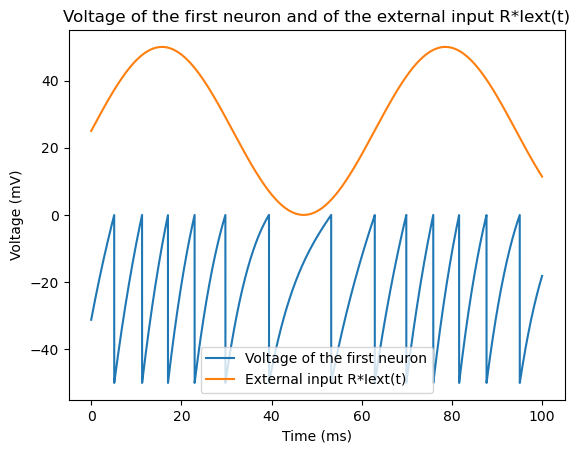

In [280]:
# Plot the voltage of the first neuron and the external input RIext(t)
plt.plot(np.arange(len(potentials[0].values))*potentials[0].dt/b2.ms, potentials[0].values/b2.mV, label='Voltage of the first neuron')
plt.plot(np.arange(len(input_current.values))*input_current.dt/b2.ms, R*input_current.values/b2.mV, label='External input R*Iext(t)')
plt.title('Voltage of the first neuron and of the external input R*Iext(t)')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.legend()
plt.show()

2. Plot the low-pass filtered activity of the population, using a time bin of τA = 1ms. Make the corresponding raster plot

In [281]:
# apply a low-pass filter to visualise and plot the network activity A(t). One will make a running average of the number of spikes in a time bin of width τA around each time t.This is equivalent to the convolution of A with a square filter. Use the function np.convolve to compute this convolution.
def low_pass_filtering(activity : b2.TimedArray, tau_A : b2.ms = 1*b2.ms):
    """apply a low-pass filter to the activity of a neuron

    Args:
        activity (b2.TimedArray): the activity of the neuron
        tau_A (b2.ms, optional): the width of the time bin. Defaults to 1*b2.ms.

    Returns:
        b2.TimedArray: the filtered activity
    """
    tau_A = int(tau_A / activity.dt) + 1
    A = np.convolve(activity.values, np.ones(tau_A)/tau_A, mode='same')
    return b2.TimedArray(A, dt=activity.dt*b2.second)

In [282]:
def network_activity(spikes : list, Tf : b2.ms, dt : b2.ms):
    """compute the network activity of a population of neurons

    Args:
        spikes (list): the spiking activity of each neuron
        Tf (b2.ms): final time of the simulation
        dt (b2.ms): dt of the simulation

    Returns:
        b2.TimedArray: the network activity of the population for each timestep
    """
    A = []
    for k in range(int(Tf / dt) + 1):
        A.append(sum([spikes[neuron][k] for neuron in range(len(spikes))]) / len(spikes) / (dt/b2.second))
    return b2.TimedArray(A, dt=dt)

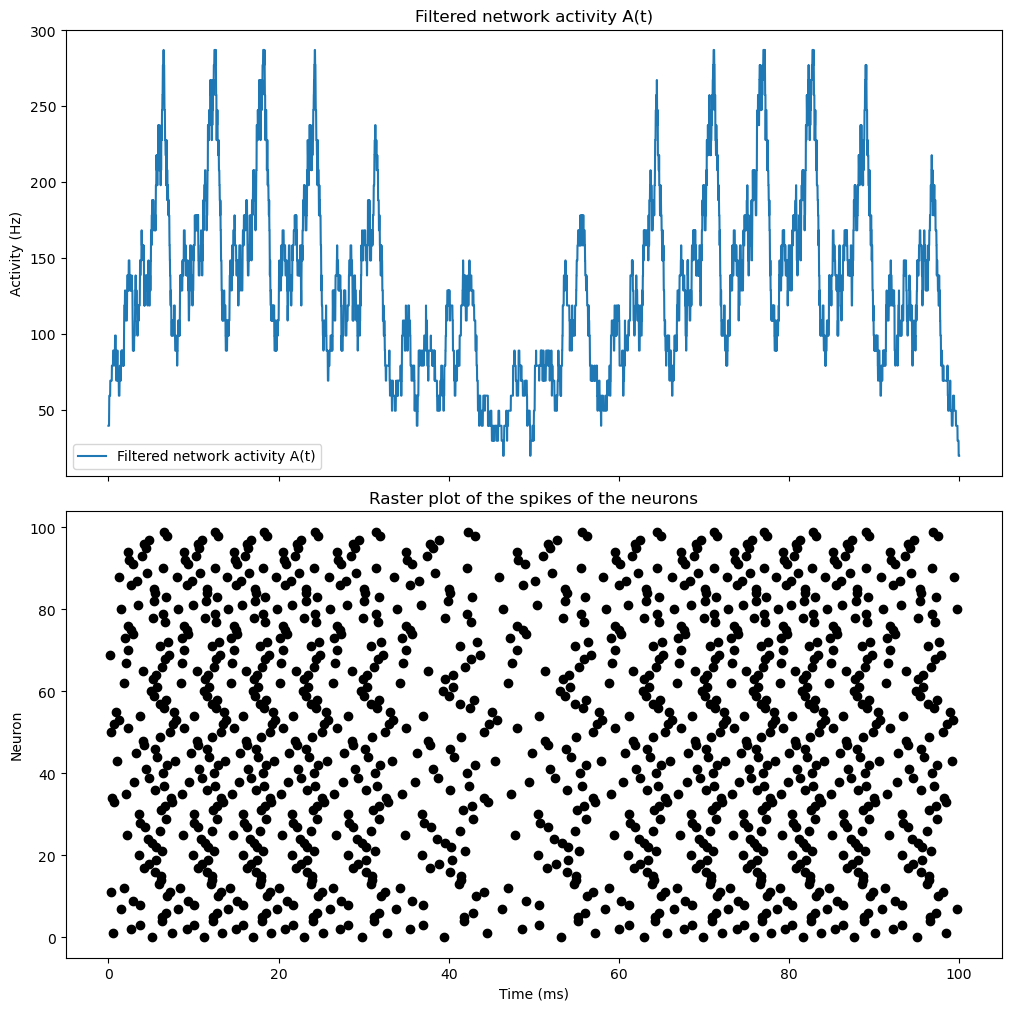

In [288]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True, constrained_layout=True)

# Plot the filtered network activity A(t) after applying a low-pass filter
A_filtered = low_pass_filtering(network_activity(spikes, Tf, dt))
ax[0].plot(np.arange(len(A_filtered.values))*A_filtered.dt/b2.ms, A_filtered.values, label='Filtered network activity A(t)')
ax[0].set_title('Filtered network activity A(t)')
ax[0].set_ylabel('Activity (Hz)')
ax[0].legend()

# Raster plot of the spikes of the neurons
for neuron in range(len(spikes)):
    spiking_time = np.where(spikes[neuron])[0]*A_filtered.dt/b2.ms
    ax[1].scatter(spiking_time, np.ones(len(spiking_time))*neuron, color='black')
ax[1].set_title('Raster plot of the spikes of the neurons')
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel('Neuron')
plt.show()